<a href="https://colab.research.google.com/github/nimamt/machine_learning/blob/master/PyTorchCharLvlRNNGenNames.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://pytorch.org/tutorials/intermediate/char_rnn_generation_tutorial.html

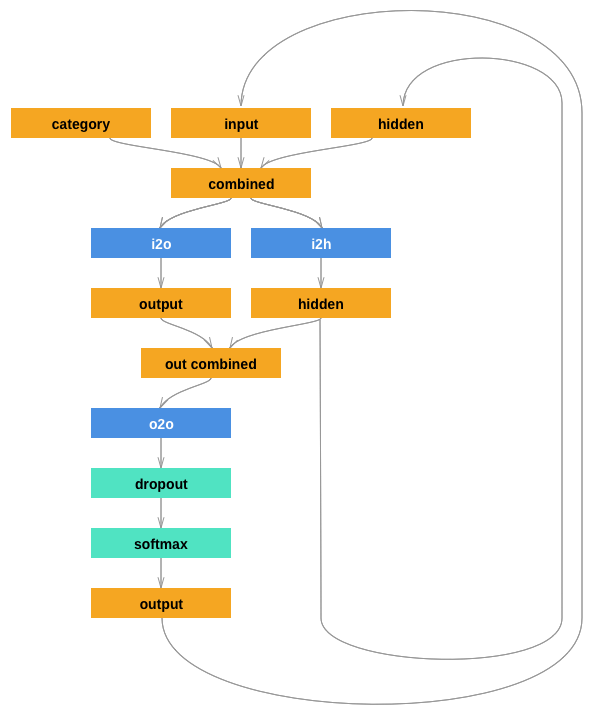

In [ ]:
base_path = "/content/drive/MyDrive/PyTorchRNNData/"

In [ ]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os

def findFiles(path): return glob.glob(path)

print(findFiles(base_path + 'data/names/*.txt'))

import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))

# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles(base_path + 'data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    print(category)
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

['/content/drive/MyDrive/PyTorchRNNData/data/names/Greek.txt', '/content/drive/MyDrive/PyTorchRNNData/data/names/Scottish.txt', '/content/drive/MyDrive/PyTorchRNNData/data/names/Russian.txt', '/content/drive/MyDrive/PyTorchRNNData/data/names/English.txt', '/content/drive/MyDrive/PyTorchRNNData/data/names/Polish.txt', '/content/drive/MyDrive/PyTorchRNNData/data/names/Portuguese.txt', '/content/drive/MyDrive/PyTorchRNNData/data/names/German.txt', '/content/drive/MyDrive/PyTorchRNNData/data/names/Chinese.txt', '/content/drive/MyDrive/PyTorchRNNData/data/names/Arabic.txt', '/content/drive/MyDrive/PyTorchRNNData/data/names/Dutch.txt', '/content/drive/MyDrive/PyTorchRNNData/data/names/Czech.txt', '/content/drive/MyDrive/PyTorchRNNData/data/names/Japanese.txt', '/content/drive/MyDrive/PyTorchRNNData/data/names/Korean.txt', '/content/drive/MyDrive/PyTorchRNNData/data/names/French.txt', '/content/drive/MyDrive/PyTorchRNNData/data/names/Italian.txt', '/content/drive/MyDrive/PyTorchRNNData/data/n

In [ ]:
import torch
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size

        self.i2h = nn.Linear(n_categories + input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(n_categories + input_size + hidden_size, output_size)
        self.o2o = nn.Linear(hidden_size + output_size, output_size)
        self.dropout = nn.Dropout(0.1)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, category, input, hidden):
        input_combined = torch.cat((category, input, hidden), 1)
        hidden = self.i2h(input_combined)
        output = self.i2o(input_combined)
        output_combined = torch.cat((hidden, output), 1)
        output = self.o2o(output_combined)
        output = self.dropout(output)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

Training

In [ ]:
import random

# Random item from a list
def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

# Get a random category and random line from that category
def randomTrainingPair():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    return category, line

In [ ]:
# One-hot vector for category
def categoryTensor(category):
    li = all_categories.index(category)
    tensor = torch.zeros(1, n_categories)
    tensor[0][li] = 1
    return tensor

# One-hot matrix of first to last letters (not including EOS) for input
def inputTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li in range(len(line)):
        letter = line[li]
        tensor[li][0][all_letters.find(letter)] = 1
    return tensor

# LongTensor of second letter to end (EOS) for target
def targetTensor(line):
    letter_indexes = [all_letters.find(line[li]) for li in range(1, len(line))]
    letter_indexes.append(n_letters - 1) # EOS
    return torch.LongTensor(letter_indexes)

In [ ]:
# Make category, input, and target tensors from a random category, line pair
def randomTrainingExample():
    category, line = randomTrainingPair()
    category_tensor = categoryTensor(category)
    input_line_tensor = inputTensor(line)
    target_line_tensor = targetTensor(line)
    return category_tensor, input_line_tensor, target_line_tensor

In contrast to classification, where only the last output is used, we are making a prediction at every step, so we are calculating loss at every step.

The magic of autograd allows you to simply sum these losses at each step and call backward at the end.

In [ ]:
criterion = nn.NLLLoss()

learning_rate = 0.0005

def train(category_tensor, input_line_tensor, target_line_tensor):
    target_line_tensor.unsqueeze_(-1)
    hidden = rnn.initHidden()

    rnn.zero_grad()

    loss = 0

    for i in range(input_line_tensor.size(0)):
        output, hidden = rnn(category_tensor, input_line_tensor[i], hidden)
        l = criterion(output, target_line_tensor[i])
        loss += l

    loss.backward()

    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item() / input_line_tensor.size(0)

In [ ]:
import time
import math

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [ ]:
rnn = RNN(n_letters, 128, n_letters)

n_iters = 100000
print_every = 5000
plot_every = 500
all_losses = []
total_loss = 0 # Reset every plot_every iters

start = time.time()

for iter in range(1, n_iters + 1):
    output, loss = train(*randomTrainingExample())
    total_loss += loss

    if iter % print_every == 0:
        print('%s (%d %d%%) %.4f' % (timeSince(start), iter, iter / n_iters * 100, loss))

    if iter % plot_every == 0:
        all_losses.append(total_loss / plot_every)
        total_loss = 0

0m 14s (5000 5%) 3.1850
0m 28s (10000 10%) 2.1805
0m 42s (15000 15%) 3.2572
0m 57s (20000 20%) 2.9292
1m 11s (25000 25%) 2.0831
1m 25s (30000 30%) 2.5922
1m 39s (35000 35%) 2.5410
1m 54s (40000 40%) 2.5153
2m 8s (45000 45%) 2.3688
2m 22s (50000 50%) 1.5191
2m 38s (55000 55%) 2.9560
2m 52s (60000 60%) 2.7036
3m 6s (65000 65%) 1.9512
3m 20s (70000 70%) 2.4589
3m 35s (75000 75%) 2.5230
3m 49s (80000 80%) 2.5809
4m 3s (85000 85%) 2.9047
4m 17s (90000 90%) 2.8127
4m 31s (95000 95%) 2.0654
4m 45s (100000 100%) 2.1485


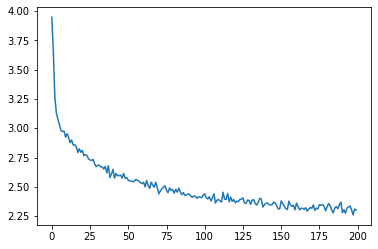

In [ ]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(all_losses)

In [ ]:
max_length = 20

# Sample from a category and starting letter
def sample(category, start_letter='A'):
    with torch.no_grad():  # no need to track history in sampling
        category_tensor = categoryTensor(category)
        input = inputTensor(start_letter)
        hidden = rnn.initHidden()

        output_name = start_letter

        for i in range(max_length):
            output, hidden = rnn(category_tensor, input[0], hidden)
            topv, topi = output.topk(1)
            topi = topi[0][0]
            if topi == n_letters - 1:
                break
            else:
                letter = all_letters[topi]
                output_name += letter
            input = inputTensor(letter)

        return output_name

# Get multiple samples from one category and multiple starting letters
def samples(category, start_letters='ABC'):
    for start_letter in start_letters:
        print(sample(category, start_letter))

samples('Russian', 'RUS')

samples('German', 'GER')

samples('Spanish', 'SPA')

samples('Chinese', 'CHI')

Roukon
Uanton
Shaki
Gerten
Erenger
Roun
Serra
Parer
Allero
Chan
Han
Iung
